In [33]:
import pandas as pd
#import networkx as nx          # on l'utilise pas ????
import matplotlib.pyplot as plt
import ast
import requests
from scipy import stats
import seaborn as sns

# 0. Loading the data

In [2]:
#load data/moviesummaries/character.metadata.tsv
character_metadata = pd.read_csv('../data/moviesummaries/character.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/plot_summaries.txt
plot_summaries = pd.read_csv('../data/moviesummaries/plot_summaries.txt', sep='\t', header=None)

#load data/moviesummaries/movie.metadata.tsv
movie_metadata = pd.read_csv('../data/moviesummaries/movie.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/name.clusters.txt
name_clusters = pd.read_csv('../data/moviesummaries/name.clusters.txt', sep='\t', header=None)


In [3]:
# Rename columns of each dataset to match documentation
character_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", 
                              "Actor height", "Actor ethnicity", "Actor name", "Actor age", "Freebase character/actor map ID", 
                              "Freebase character ID", "Freebase actor ID"]

plot_summaries.columns = ["Wikipedia movie ID", "Summary"]

movie_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie revenue", "Movie runtime",
                          "Movie languages", "Movie countries", "Movie genres"]

name_clusters.columns = ["Character name", "Freebase character/actor map ID"]

We get 4 different dataframes; we'll merge movie_metadata and plot_summaries together since it makes sense to get the plot information directly linked with the movie metadata, and keep the others as is.

# 1. Preprocessing plot and metadata about movies

We can see from the columns name that we can simply add the plot summaries of the movies to the movie metadata dataframe. Let's first take a look at how many data we have in each dataset :

In [4]:
# Print the size of each dataset
print("Number of data in the metadata dataframe :", movie_metadata.shape[0])
print("Number of data in the plot summaries dataframe :", plot_summaries.shape[0])

Number of data in the metadata dataframe : 81741
Number of data in the plot summaries dataframe : 42303


We can see that approximately half of the movies in the metadata have a plot description. Let's now join the two dataset on the ID column :

In [5]:
# Merge the movie_metadata and plot_summaries dataframes on the Wikipedia movie ID, without dropping the rows whitout summary, but dropping
# the plot without a matching movie
all_movies = movie_metadata.merge(plot_summaries, on="Wikipedia movie ID", how="left")
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [6]:
# Check the number and percentage of null values in each column of plot_summaries as well as the number of different values in each column.
all_movies_null = pd.DataFrame(all_movies.isnull().sum(), columns=['Number of null values'])
all_movies_null['Percentage of null values'] = all_movies_null['Number of null values'] / len(all_movies)
all_movies_null['Number of unique values'] = all_movies.nunique()

all_movies_null

,Number of null values,Percentage of null values,Number of unique values
Wikipedia movie ID,0,0.000000,81741
Freebase movie ID,0,0.000000,81741
Movie name,0,0.000000,75478
Movie release date,6902,0.084437,20389
Movie revenue,73340,0.897224,7362
Movie runtime,20450,0.250180,597
Movie languages,0,0.000000,1817
Movie countries,0,0.000000,2124
Movie genres,0,0.000000,23817
Summary,39537,0.483686,42196


As mentioned above, we see that approximately 48% percent of the movie dataset doesn't have a corresponding plot summary!

But what about dupplicated plot summaries? Let's check that :

In [7]:
# Show plot summary duplicates which are not NaNs
duplicate_plot_movies = all_movies[all_movies.duplicated(subset=['Summary'], keep = False) & all_movies['Summary'].notnull()]

# Print number of plot summaries having at least one duplicate
print("Number of plot summaries having at least one duplicate :", duplicate_plot_movies['Summary'].nunique())

duplicate_plot_movies[['Wikipedia movie ID', 'Movie name', 'Summary']].sort_values(by=['Summary'])


Number of plot summaries having at least one duplicate : 5


,Wikipedia movie ID,Movie name,Summary
4551,14055212,The Trial of Madame X,A woman is thrown out of her home by her jealo...
18993,14022275,Madame X,A woman is thrown out of her home by her jealo...
49381,14037732,Madame X,A woman is thrown out of her home by her jealo...
57569,14051944,Madame X,A woman is thrown out of her home by her jealo...
65014,14053389,Madame X,A woman is thrown out of her home by her jealo...
28621,29481480,Drohi,An orphan Raghav turns into a ruthless contrac...
67464,25493367,Antham,An orphan Raghav turns into a ruthless contrac...
15783,14616220,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
57508,28852030,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
22185,19609453,Amar Deep,Raja was adopted by a criminal don at a very ...


We see that there are 5 different plot summaries that have at least one duplicate. 

In some cases, the duplicate has the same movie name but in other cases, the duplicate has a different movie name. 

Therefore, we can't choose which duplicate is the "correct" one.

We therefore choose here either to discard all duplicates or to keep them all.

ICI PEUT ETRE LES ENLEVER? 
duplicate de ligne, mais pas les autres

## Data cleaning

### Movie release date


Let's now take a look at the movies release dates. By looking at the data, we see 4 cases :
 - The release date is a year 
 - The release date is a month and a year 
 - The release date is a day, a month and a year 
 - The release date is not a number

Let's convert every entry to only a year when it's possible :

Defining three functions checking which format is valid for a specific string

In [8]:
# import the datetime module
import datetime

 # Function to check if a string matches the specified date format
 
 # For format 1 : YYYY-MM-DD
def valid_format1(date_string, date_format='%Y-%m-%d'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False

# For format 2 : YYYY-MM
def valid_format2(date_string, date_format='%Y-%m'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False   

# For format 3 : YYYY
def valid_format3(date_string, date_format='%Y'):
    try:
        datetime.datetime.strptime(date_string, date_format)
        return True
    except ValueError:
        return False
        

Creating a function to keep only the year, if the data is in one of the three formats defined above

In [9]:
import datetime
import pandas as pd
import numpy as np

def keep_the_year(date_full, key):
    
    # Converting tyhe date full column to a dataframe, and replacing the nan with null values
    date_full = pd.DataFrame(date_full)
    date_full  = date_full.fillna(" ")
    
    # creating a dataframe with the same size as date_full, but with nan values
    date_formated = pd.DataFrame(np.nan, index=date_full.index, columns=date_full.columns) 

    # Define date formats
    format1 = '%Y-%m-%d'
    format2 = '%Y-%m'
    format3 = '%Y'

    # Iterate through the values in the datefull column, checking which format it matches, and converting it to datetime format
    for (index,i) in enumerate(date_full[key]):
        if valid_format1(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format1).date()
        elif valid_format2(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format2).date()
        elif valid_format3(i):
            date_formated[key][index] = datetime.datetime.strptime(i, format3).date()
        
    #  Keeping only the year 
    date_year = pd.DatetimeIndex(date_formated[key]).year
    #Converting to int
    date_year = date_year.astype('Int64')
    return date_year

Converting the movie release date to keep only the year for the all_movie table :

In [10]:
# Setting out of bound values to nan
all_movies['Movie release date'][62836] = np.nan
# Calling the function
all_movies['Movie release date'] = keep_the_year(all_movies['Movie release date'], key='Movie release date')

/var/folders/g9/m8h3jr8d7dldf2nch79wndhh0000gn/T/ipykernel_52735/2584046882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies['Movie release date'][62836] = np.nan
/var/folders/g9/m8h3jr8d7dldf2nch79wndhh0000gn/T/ipykernel_52735/2949234143.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2001-08-24' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  date_formated[key][index] = datetime.datetime.strptime(i, format1).date()


In [11]:
all_movies.head(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",NaN
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",NaN
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",NaN


### Dictionnary structures

In [12]:
# Print examples of the 'Movie countries', 'Movie genres' and 'Movie languages' columns as well as their types
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

{"/m/09c7w0": "United States of America"}
<class 'str'>
{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}
<class 'str'>
{"/m/02h40lc": "English Language"}
<class 'str'>


We see that some columns are written as a dictionnary but saved as a string. 

Three columns are concerned by this problem:
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

Let's convert these columns back to dictionnaries to be able to use this structure.

In [13]:
all_movies['Movie countries'] = all_movies['Movie countries'].apply(ast.literal_eval)
all_movies['Movie genres'] = all_movies['Movie genres'].apply(ast.literal_eval)
all_movies['Movie languages'] = all_movies['Movie languages'].apply(ast.literal_eval)
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

{'/m/09c7w0': 'United States of America'}
<class 'dict'>
{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science Fiction', '/m/03npn': 'Horror', '/m/03k9fj': 'Adventure', '/m/0fdjb': 'Supernatural', '/m/02kdv5l': 'Action', '/m/09zvmj': 'Space western'}
<class 'dict'>
{'/m/02h40lc': 'English Language'}
<class 'dict'>


Now, we have a proper dataframe containing metadata and plot summaries about movies: all_movies

# 2. Preprocessing characters metadata

In [14]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
216687,2685258,/m/07xwyr,1923,NaN,NaN,M,NaN,NaN,Erwin Connelly,NaN,/m/0bvb1cb,NaN,/m/0k328v
75235,19878462,/m/04lgxyt,2008,NaN,1998-04-15,F,NaN,NaN,Sharlene San Pedro,9.0,/m/0gcxcgs,NaN,/m/03bxpx9
276962,15926836,/m/03qh022,1997-02-27,NaN,1965-03-26,M,NaN,/m/075_n6,Prakash Raj,31.0,/m/05t9h0h,NaN,/m/09tqx3
60949,28893425,/m/0dgrqsx,NaN,NaN,1977-02-15,F,NaN,NaN,Rachida Brakni,NaN,/m/0gvxchg,NaN,/m/0bx6z1
201593,32716237,/m/0b4cpj1,1939,NaN,1907-10-14,M,NaN,NaN,Allan Jones,31.0,/m/0h40234,NaN,/m/02pps6
299989,20992613,/m/05b50wb,2008,NaN,NaN,NaN,NaN,NaN,Lyubov Tymoshevska,NaN,/m/0ghx0rv,NaN,/m/0ghx0rs
330777,54173,/m/0f4_l,1994-05,Woman in Bathroom,NaN,F,NaN,NaN,Ani Sava,NaN,/m/0bhh1m4,/m/0bhh1m7,/m/0bhh1mg
350927,20581361,/m/052049h,NaN,Tuna's Boyfriend,1923-11-11,M,NaN,/m/0dryh9k,Johnny Walker,NaN,/m/0h6_rfm,/m/0h6_rfq,/m/07l4kn
293101,2743131,/m/080bt_,1968-07-08,NaN,NaN,M,NaN,NaN,George Birt,NaN,/m/0bxrqjc,NaN,/m/0bxrqj8
271136,729979,/m/036cds,2000-05-14,Daniel,NaN,M,NaN,NaN,Álvaro Guerrero,NaN,/m/0jtfsp,/m/0bbdd5l,/m/0czmyz


Taking a quick look, we see that we encounter the same problem with the "Movie release date" and the "Actor date of birth" columns as seen before. Let's convert every entry to only a year when it's possible :

In [15]:
# Setting out of bound value to nan
character_metadata['Movie release date'][67624:67639] = np.nan
# Calling the function
character_metadata['Movie release date'] = keep_the_year(character_metadata['Movie release date'], key='Movie release date')

/var/folders/g9/m8h3jr8d7dldf2nch79wndhh0000gn/T/ipykernel_52735/1576258549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  character_metadata['Movie release date'][67624:67639] = np.nan
/var/folders/g9/m8h3jr8d7dldf2nch79wndhh0000gn/T/ipykernel_52735/2949234143.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2001-08-24' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  date_formated[key][index] = datetime.datetime.strptime(i, format1).date()


## For the actor date of birth, too many out of bounds values, is it really usefull to convert it since we already have their age ?

In [16]:
#character_metadata['Actor date of birth'][11550] = np.nan
#character_metadata['Actor date of birth'][39427] = np.nan
#character_metadata['Actor date of birth'][42283] = np.nan
#character_metadata['Actor date of birth'][45080] = np.nan
#character_metadata['Actor date of birth'][80339] = np.nan
#character_metadata['Actor date of birth'] = keep_the_year(character_metadata['Actor date of birth'], key='Actor date of birth')

In [17]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
44610,28493168,/m/0crbtd5,2007,NaN,NaN,NaN,NaN,NaN,Ljubomir Jurkovic,NaN,/m/0g9g2jm,NaN,/m/0g9g2jq
88066,99123,/m/0pb33,1994,Additional Bus Passenger #3,NaN,F,NaN,NaN,Sonia Jackson,NaN,/m/0bh35hz,/m/0bh35j1,/m/0bh35j8
268451,296252,/m/01r92q,1999,Yevgeny Nourish,1963-08-17,M,NaN,/m/044038p,Don McKellar,35.0,/m/0jxzwg,/m/0g9d4ym,/m/05d1dy
153375,3732970,/m/09xytj,1935,NaN,1895-06-14,M,1.66,NaN,Cliff Edwards,NaN,/m/04l4ktw,NaN,/m/01mgdm3
54151,10870536,/m/02qslnw,1941,Millie Pickens,1917-06-30,F,1.60,/m/065b6q,Susan Hayward,23.0,/m/02vd364,/m/0h5b_pc,/m/01938t
303182,14460630,/m/03d47y4,1997,NaN,1956-08-30,M,NaN,NaN,Ismaël Lô,40.0,/m/0bgbpqt,NaN,/m/01p58mm
137210,24808831,/m/080kmxp,2009,NaN,NaN,NaN,NaN,NaN,Shelly Burch,NaN,/m/0gc1y56,NaN,/m/0gby2rx
401033,28490522,/m/0g5ycgt,1970,NaN,1943-01-01,F,NaN,NaN,Inge Apelt,27.0,/m/0gb02zx,NaN,/m/0gb02z_
68263,6790266,/m/0gp21g,1994,NaN,NaN,M,NaN,NaN,Vic Manni,NaN,/m/0gdk_2d,NaN,/m/0gpnfr
433317,5501736,/m/0dpq1q,1970,NaN,NaN,F,NaN,NaN,Doreen Keogh,NaN,/m/0gbzrsw,NaN,/m/03cc_9w


# 3. Learning more about the data

### Chronological evolution of movie production

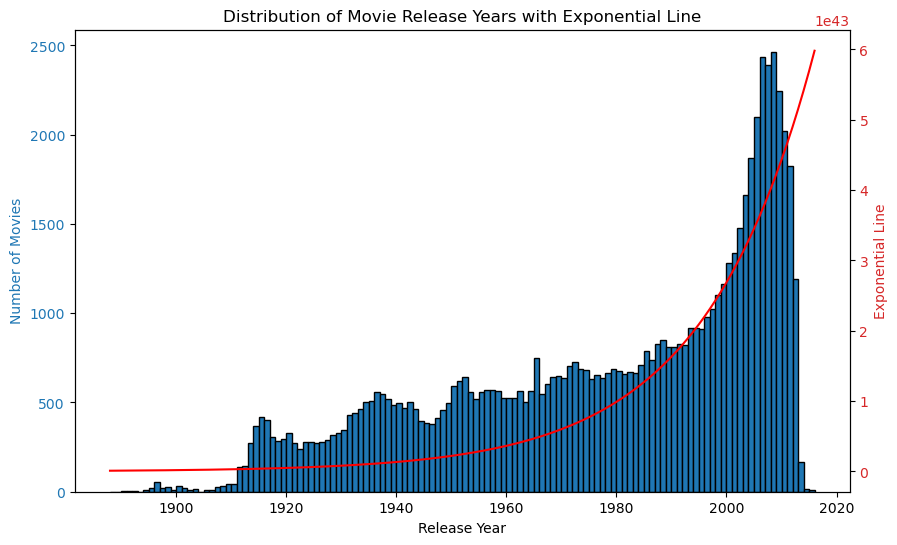

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating an histogram plotting the values of 'year'
ax1.hist(all_movies['Movie release date'].dropna(), bins=range(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1), edgecolor='black', label='Movie Releases')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Adding an exponential line
ax2 = ax1.twinx()
x_values = np.arange(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1, 1)
y_values = np.exp(0.05 * x_values)  # You can adjust the exponent and other parameters
ax2.plot(x_values, y_values, label='Exponential Line', color='red')
ax2.set_ylabel('Exponential Line', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Movie Release Years with Exponential Line')
plt.show()

-> We have way more data for recent films

### Movie countries and genres

In [19]:
# Definition of a function to extract unique values from a column of dictionaries

def extract_unique_values(df, column_name):
    all_values = set()

    for values_dict in df[column_name]:
        all_values.update(values_dict.values())

    # Convert the set of values back to a list if needed
    unique_values_list = list(all_values)

    return unique_values_list

In [20]:
# Print number of unique movie countries, genres and languages

unique_countries_list = extract_unique_values(all_movies, 'Movie countries')
unique_genres_list = extract_unique_values(all_movies, 'Movie genres')
unique_languages_list = extract_unique_values(all_movies, 'Movie languages')

print('Number of unique movie countries:', len(unique_countries_list))
print('Number of unique movie genres:', len(unique_genres_list))
print('Number of unique movie languages:', len(unique_languages_list))

Number of unique movie countries: 147
Number of unique movie genres: 363
Number of unique movie languages: 207


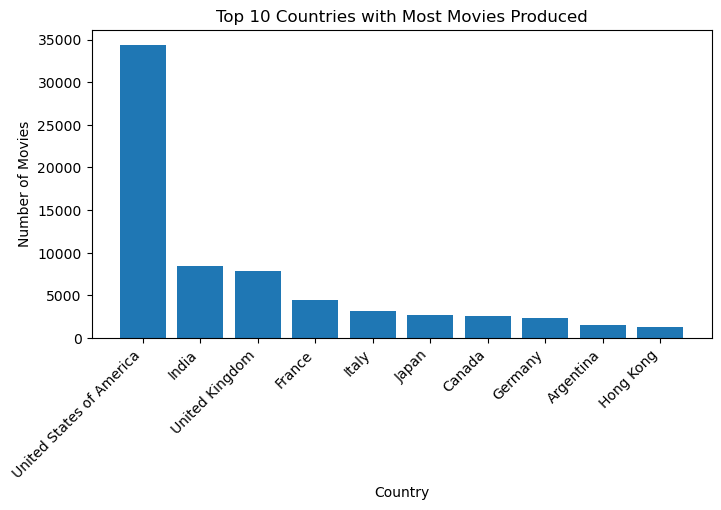

The top 1 production country is United States of America and concerns 39.81% of all movies produced.


In [21]:
# Compute a box plot of top 10 countries with most movies produced
# Flatten the countries and count the occurrences
country_counts = {}

for country_dict in all_movies['Movie countries']:
    for country in country_dict.values():
        country_counts[country] = country_counts.get(country, 0) + 1

# Get the top 10 countries
top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top countries
top_countries_df = pd.DataFrame(top_countries, columns=['Country', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_countries_df['Country'], top_countries_df['Count'])
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Top 10 Countries with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 country and its percentage
top_1_country = top_countries_df['Country'].iloc[0]
percentage = country_counts[top_1_country] / sum(country_counts.values()) * 100
print(f'The top 1 production country is {top_1_country} and concerns {percentage:.2f}% of all movies produced.')

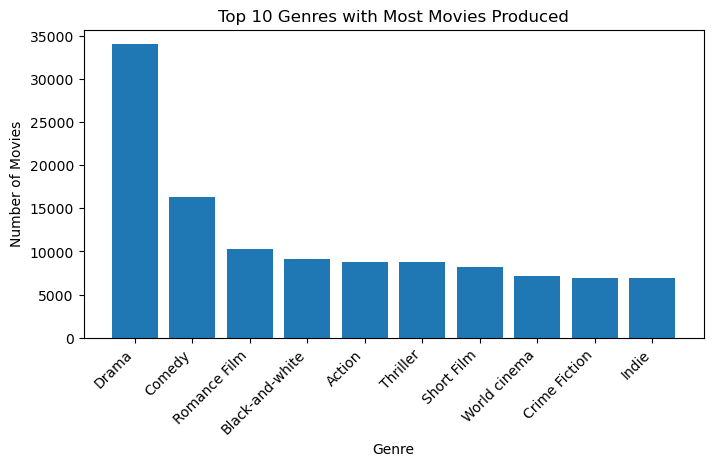

The top 1 genre is Drama and represents 13.98% of all movies produced.


In [22]:
# Compute a box plot of top 10 genres with most movies produced
# Flatten the genres and count the occurrences
genre_counts = {}

for genres_dict in all_movies['Movie genres']:
    for genre in genres_dict.values():
        genre_counts[genre] = genre_counts.get(genre, 0) + 1

# Get the top 10 genres
top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_genres_df['Genre'], top_genres_df['Count'])
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Genres with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_genre = top_genres_df['Genre'].iloc[0]
percentage = genre_counts[top_1_genre] / sum(genre_counts.values()) * 100
print(f'The top 1 genre is {top_1_genre} and represents {percentage:.2f}% of all movies produced.')

These results show us that an analysis of the whole dataset will actually be more representative of movies produced or co-produced in the USA and movies belonging to the genre Drama. 

## Missing values plutôt ici => enlever dans partie 1 ??

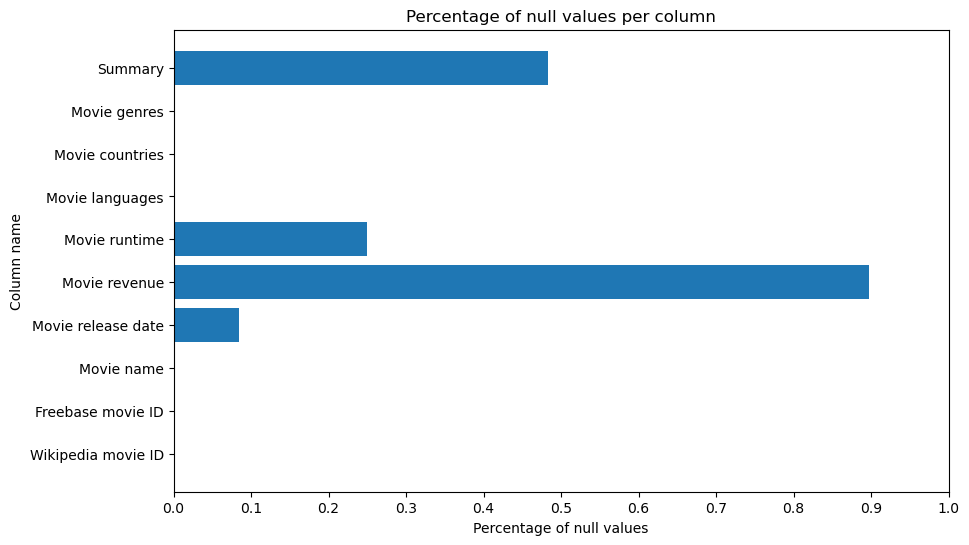

In [32]:
# plot the percentage of missing values for all columns in the all_movies dataframe
plt.figure(figsize=(10, 6))
plt.barh(all_movies_null.index, all_movies_null['Percentage of null values'])
plt.xlabel('Percentage of null values')
plt.ylabel('Column name')
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.title('Percentage of null values per column')
plt.show()

We see that there are a lot of missing values of the movie revenues (around 90%), we need to find another metric for judging films popularity. IMDb ratings seem to be a good alternative. This dataset contains the average IMDb rating of movies and the number of votes.

# 4. Add IMDb ratings

### Load the data

In [24]:
movie_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t', header=0)

In [25]:
movie_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


### Use Wikidata query to create a table that link IMDb identifier tconst with Freebase ID

Since multiple movies have the same name and appear the same year, we have to link the two dataset using freebase ID of the movies in the original dataset and the unique identifier tconst of the IMDb ratings dataset. We use Wikidata query to create a link table

In [26]:
# Define a function that uses wikidata queries to link Freebase movie ID and IMDb tconst

def link_tconst_freebaseID():
    url = 'https://query.wikidata.org/sparql'

    # Query to get freebase ID and IMDb ID
    # wdt:P345 IMDb ID in wikidata
    # wdt:P646 Freebase ID in wikidata
    query = """
    SELECT ?item ?tconst ?freebaseID WHERE {
        ?item wdt:P345 ?tconst.
        OPTIONAL {?item wdt:P646 ?freebaseID}
    }
    """

    # Query
    params = {'query': query, 'format': 'json'}
    # headers = {'User-Agent': 'WDQS-example Python/%s.%s' % (sys.version_info[0], sys.version_info[1])}
    data = requests.get(url ,params = params).json()

    # Create a dataframe that link IMDb tconst and freebaseID
    tconst = []
    freebase_id = []
    for item in data['results']['bindings']:
        tconst.append(item['tconst']['value'])
        freebase_id_val = item.get('freebaseID', {}).get('value', np.nan)
        freebase_id.append(freebase_id_val)

    return pd.DataFrame(data={'tconst': tconst, 'Freebase movie ID': freebase_id})


In [27]:
# Create the table
link_id = link_tconst_freebaseID()

# Drop duplicates
link_id = link_id.drop_duplicates(subset=['tconst'])
link_id = link_id.drop_duplicates(subset=['Freebase movie ID'])

link_id.head()

,tconst,Freebase movie ID
0,tt13052880,NaN
1,nm1917778,/m/015srx
2,nm1587340,/m/05myrr
3,nm2682772,/m/01vgs9j
5,tt0049876,/m/04n4klb


### Merge the two datasets

In [28]:
# Add freebase ID to movie_ratings
movie_ratings = pd.merge(movie_ratings, link_id, on='tconst', how='left')
movie_ratings.head()

,tconst,averageRating,numVotes,Freebase movie ID
0,tt0000001,5.7,2006,/m/0kvdsy
1,tt0000002,5.8,269,/m/02pz844
2,tt0000003,6.5,1909,/m/0g53g2
3,tt0000004,5.5,178,/m/02pzdsc
4,tt0000005,6.2,2689,/m/0jq3g


In [29]:
# Merge all_movies and movie_ratings
all_movies = pd.merge(all_movies, movie_ratings, on='Freebase movie ID', how='left')
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","Set in the second half of the 22nd century, th...",tt0228333,4.9,56908.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",NaN,tt0245916,6.0,69.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",NaN,tt0094806,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",A series of murders of rich young women throug...,tt0094320,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},"Eva, an upper class housewife, becomes frustra...",tt0083949,5.9,623.0


In [30]:
# Percentage of missing values in the columns averageRatings and num votes
print('Percentage of missing values in averageRatings:', all_movies['averageRating'].isnull().sum() / len(all_movies))
print('Percentage of missing values in numVotes:', all_movies['numVotes'].isnull().sum() / len(all_movies))

Percentage of missing values in averageRatings: 0.16998813325014375
Percentage of missing values in numVotes: 0.16998813325014375


We have far fewer missing values in ratings than in revenues.

### Correlation between movie revenue and average rating

Percentage of movies for which we have both informations:  0.10183384103448698 
 

Person correlation between movie revenue and average rating:  PearsonRResult(statistic=0.16823475825985915, pvalue=6.76337726428832e-54) 
 



/Users/romainbianchi/opt/anaconda3/envs/ada2/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


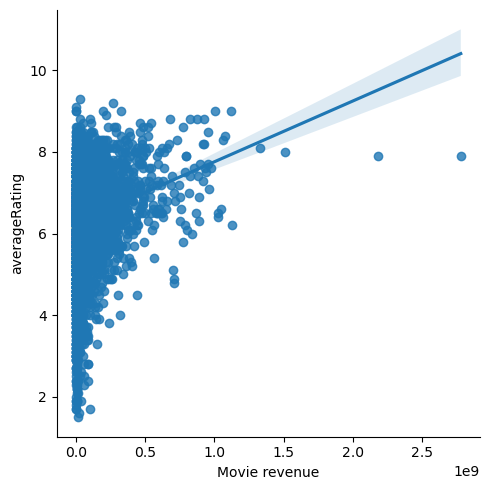

In [46]:
# Keep movies for which we have both informations
df1 = all_movies.dropna(subset=['Movie revenue', 'averageRating'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: ", len(df1) / len(all_movies), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
print("Person correlation between movie revenue and average rating: ", stats.pearsonr(df1['Movie revenue'], df1['averageRating']), '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='averageRating', data=df1)

There is a significant positive correlation between a movie revenue and its average rating.

### Correlation between movie revenue and number of votes for rating

Percentage of movies for which we have both informations:  0.10183384103448698 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=0.6550136090668377, pvalue=0.0) 
 



/Users/romainbianchi/opt/anaconda3/envs/ada2/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


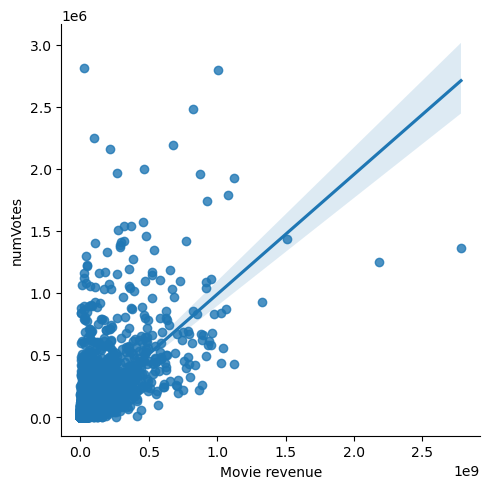

In [45]:
# Keep movies for which we have both informations
df2 = all_movies.dropna(subset=['Movie revenue', 'numVotes'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: ", len(df2) / len(all_movies), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
print("Person correlation between movie revenue and numVotes: ", stats.pearsonr(df2['Movie revenue'], df2['numVotes']), '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='numVotes', data=df2)

There is a significant positive correlation between a movie revenue and its number of votes.

## Utiliser ces corrélation pour dire que les movies ratings = metric qui va dans le même sens que les revenue ??

# À faire

 - Filtrer les datas: enlever colonnes inutiles??? à demander 
 - Enlever les duplicate complets -> 
 - Drop actor date of birth???? à demander


Partie de romain:
 - sortir % NaN des revenue 